In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm

import gym
from gym.spaces import Discrete, Tuple

from env_mp_simple import MetaGamesLimitedtraj
from rmax_1_batch_limitedtraj import RmaxAgentTraj, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return np.round(np.divide(number, radius)) * radius

def Boltzmann(arr):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    action_value = np.zeros(arr.shape[0])
    prob = softmax(arr/0.4, 1)
    for b in range(arr.shape[0]):
        action_value[b] = np.random.choice(np.arange(arr.shape[1]), p=prob[b])
    return action_value

In [8]:
bs = 1
inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0.8         #meta game discount factor

R_max = 1
meta_steps = 7

game = "PD"
epsilon = 0.8
hist_step= 3

In [9]:
# creating environment
env = MetaGamesLimitedtraj(bs, hist_step, meta_steps, game)

# creating rmax agent
memory = Memory()
rmax = RmaxAgentTraj(R_max, bs, meta_steps+1, meta_gamma, inner_gamma, epsilon, hist_step)

meta_epi = int(0.7 * rmax.m * rmax.ns)

#reward tensor for plotting purposes [bs, episode, step, agents]
plot_rew = np.zeros((bs, meta_epi, meta_steps, 2))
#visited states vs reward array, [bs, number of s-a pairs, 2], 1 for cumulative reward, 1 for number of visitation
plot_visit = np.zeros((bs, rmax.ns * rmax.na + 1, 2))    

meta_epi

11536179

In [9]:
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment 
    #initialise meta-state and meta-action randomly
    meta_s = env.reset()
   
    for step in range(meta_steps):    #for each meta time step
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        our_action = Boltzmann(rmax.Q[np.arange(bs), rmax.find_meta_index(meta_s, "s").astype(int), :])
        
        #run inner game according to actions
        obs, reward, info, _ = env.step(our_action) 
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[:,episode,step,0] = reward
        plot_rew[:,episode,step,1] = info

        #meta-action = action that corresponds to max Q(meta_s) = our inner Q
        meta_a = our_action

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = obs

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward    
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(memory, meta_s, meta_a, new_meta_s)
                    
        plot_visit[:,(rmax.nSA >= rmax.m).sum(), 0] += reward
        plot_visit[:,(rmax.nSA >= rmax.m).sum(), 1] += 1
        #prepare meta_s for next step
        meta_s = new_meta_s


  4%|█▎                                     | 2066/58844 [00:03<01:23, 681.30it/s]


KeyboardInterrupt: 

# Plots

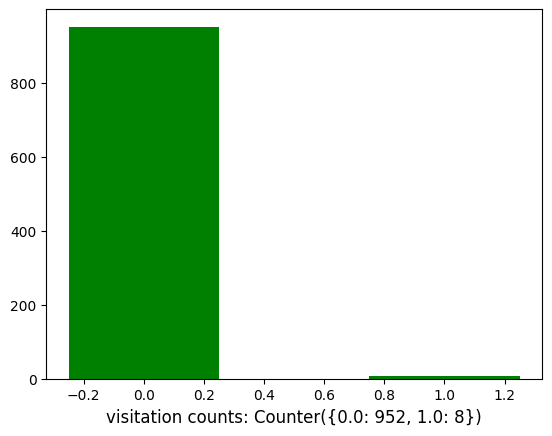

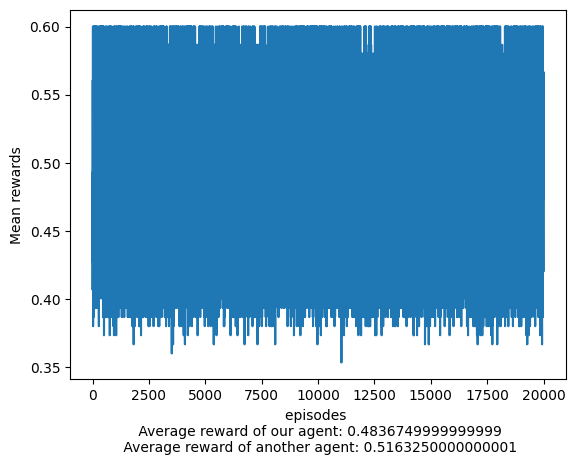

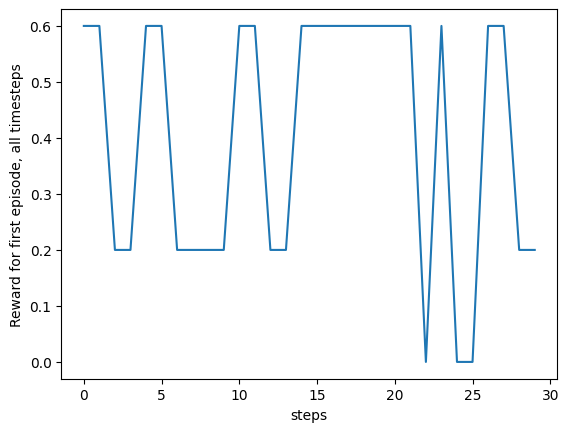

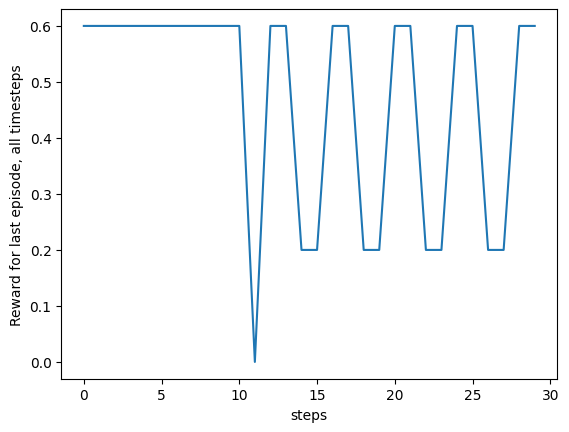

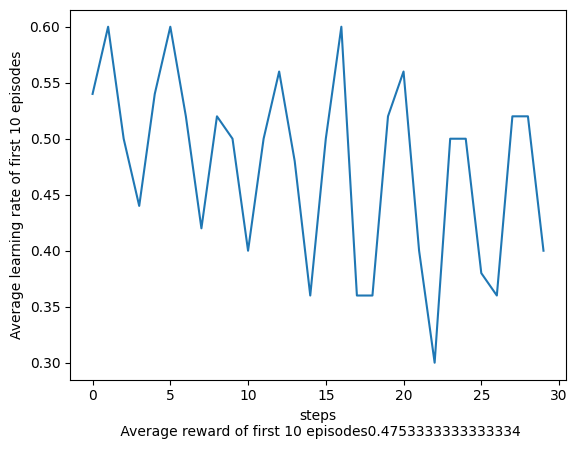

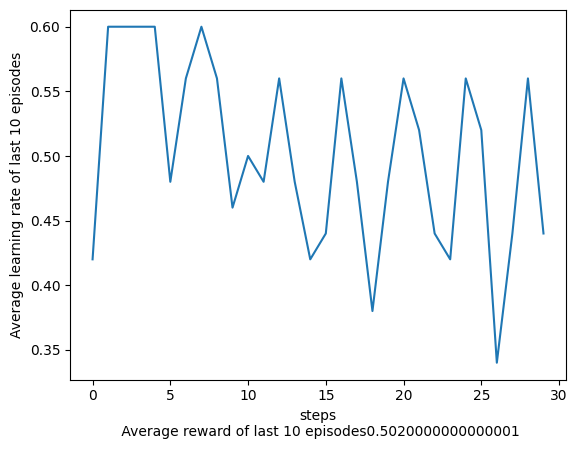

In [6]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA[0].flatten().tolist())):
    visit_dict[i]= rmax.nSA[0].flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('histogram' + str(datetime.now()) + '.png')

plt.clf()
#generate MA(5) reward 
a = np.mean(plot_rew[0,:,:,0], axis=1)
b = np.convolve(a, np.ones(int((meta_epi/10))) / (meta_epi/10), mode='valid')
fig_handle = plt.plot(b)
#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[0,:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[0,:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + " hist_step= " + str(hist_step)+
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[1] * rmax.nSA.shape[2])))

plt.ylabel("Mean rewards")

figure1 = plt.gcf() # get current figure
figure1.set_size_inches(10, 8)
plt.savefig(str(datetime.now()) + 'MA _reward' + game + "hist_step_" + str(hist_step) + '.png')

plt.clf()
#generate learning curve at start of batch 0
plot_rew_epi_start = np.mean(plot_rew[0, :10, :, 0], axis=0)
fig_handle = plt.plot(plot_rew_epi_start)

plt.xlabel("steps" + "\n Average reward of first 10 episodes" + str(np.mean(plot_rew[0,:10,:,0])))
plt.ylabel("Average learning rate of first 10 episodes")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)
plt.savefig(str(datetime.now()) + 'Learning_curve_first' + game + "hist_step_" + str(hist_step) + '.png


plt.clf()
#generate learning curve at end
plot_rew_epi_end = np.mean(plot_rew[0, -10:, :, 0], axis=0)
fig_handle = plt.plot(plot_rew_epi_end)

plt.xlabel("steps" + "\n Average reward of last 10 episodes" + str(np.mean(plot_rew[0,-10:,:,0])))
plt.ylabel("Average learning rate of last 10 episodes")
            
figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)
plt.savefig(str(datetime.now()) + 'Learning_curve_last' + game + "hist_step_" + str(hist_step) + '.png

plt.clf()
            
#Visitation vs Reward curve
yaxis = np.divide(plot_visit[0,:,0], plot_visit[0,:,1], out=np.zeros_like(plot_visit[0,:,0]), where=plot_visit[0,:,1]!=0)
fig_handle = plt.plot(yaxis)

plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)
plt.savefig(str(datetime.now()) + 'RewardVSVisitation' + game + "hist_step_" + str(hist_step) + '.png

In [ ]:
# Open a file and use dump()
with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(plot_rew, file)

# Open a file and use dump()
with open('rmax_nSA' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(rmax.nSA, file)

# Interpreting results 

In [35]:
import glob
path2 = "plot_rew*12:22*.pkl"
path3 = "rmax*12:22*.pkl"
        
for filename in glob.glob(path2):    
    with open(filename, 'rb') as g:
        plot_rew = pickle.load(g)
        
for filename in glob.glob(path3):    
    with open(filename, 'rb') as g:
        rmaxnSA = pickle.load(g)        

UnpicklingError: pickle data was truncated